<a href="https://colab.research.google.com/github/bots384/STGCNN_CRIME/blob/main/ST_GCNN_DGL_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

##Installing Libraries

In [ ]:
!pip uninstall dgl
#intalling libraries
!pip install geopandas
!pip install --pre dgl -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install wandb -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu117/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 MB 4.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 163.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

##Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
import pandas as pd
import numpy as np
import geopandas
import scipy.sparse as sp
import dgl
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from dgl.nn.pytorch import GraphConv
from dgl.nn.pytorch.conv import ChebConv
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import networkx as nx
import wandb
import pprint

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


#Utils

In [ ]:
def load_data(file_path, len_train, len_val):
    df = pd.read_csv(file_path, header=None).values.astype(float)
    train = df[:len_train]
    val = df[len_train : len_train + len_val]
    test = df[len_train + len_val :]
    return train, val, test


def data_transform(data, n_his, n_pred, device):
    # produce data slices for training and testing
    n_route = data.shape[1]
    l = len(data)
    num = l - n_his - n_pred
    x = np.zeros([num, 1, n_his, n_route])
    y = np.zeros([num, n_route])

    cnt = 0
    for i in range(l - n_his - n_pred):
        head = i
        tail = i + n_his
        x[cnt, :, :, :] = data[head:tail].reshape(1, n_his, n_route)
        y[cnt] = data[tail + n_pred - 1]
        cnt += 1
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

def data_multi_dim_transform(data, n_his, n_pred, device):
    # produce data slices for training and testing
    n_route = data.shape[2]
    l =data.shape[1]
    num = l - n_his - n_pred
    x = np.zeros([num, 1, n_his, n_route])
    y = np.zeros([num, n_route])

    cnt = 0
    for i in range(l - n_his - n_pred):
        head = i
        tail = i + n_his
        x[cnt, :, :, :] = data[head:tail].reshape(1, n_his, n_route)
        y[cnt] = data[tail + n_pred - 1]
        cnt += 1
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)


def evaluate_model(model, loss, data_iter):
    model.eval()
    l_sum, n = 0.0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            l = loss(y_pred, y)
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        return l_sum / n


def evaluate_metric(model, data_iter, scaler):
    model.eval()
    with torch.no_grad():
        mae, mape, mse = [], [], []
        for x, y in data_iter:
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(
                model(x).view(len(x), -1).cpu().numpy()
            ).reshape(-1)
            d = np.abs(y - y_pred)
            mae += d.tolist()
            mape += (d / y).tolist()
            mse += (d**2).tolist()
        MAE = np.array(mae).mean()
        MAPE = np.array(mape).mean()
        RMSE = np.sqrt(np.array(mse).mean())
        return MAE, MAPE, RMSE
def print_graph(dgl_graph, node_labels, seed, font_size=10,  font_color="red"):
    o = dgl.to_networkx(G)
    pos = nx.spring_layout(o, seed=8)
    plt.figure(figsize=[20,20])
    nx.draw_networkx_edges(G=o, pos=pos)
    nx.draw_networkx_labels(G=o, pos=pos,  labels=node_labels, font_size=font_size, font_color=font_color)

#Loading Datasets

In [ ]:
#mounting google drive
#drive.mount('/content/drive')

All datasets are uploaded and public available [here](https://drive.google.com/drive/folders/1PJ546bfKSWznTbw-j4FtWvnVlfvprY2N?usp=share_link)

path '/content/drive/MyDrive/datasets/nyc_borough_df.csv'  is used if the dataset is stored in the mounted Google Drive.
If not.
url 'https://drive.google.com/u/0/uc?id=110YYV4_NRpiECERZSLIXJzB9sc4DMbfO&export=download&confirm=t' type path with the corresponding id can be used to download
the dataset from a Google Drive link with public access

NYC Complaint Dataset (with neighborhoods) is uploaded and public available [here](https://drive.google.com/file/d/110YYV4_NRpiECERZSLIXJzB9sc4DMbfO/view?usp=share_link) with id = 110YYV4_NRpiECERZSLIXJzB9sc4DMbfO


In [ ]:
#nyc_borough_df = pd.read_csv('/content/drive/MyDrive/datasets/nyc_borough_df.csv', parse_dates=['DATE_TIME'])
google_drive_id = '110YYV4_NRpiECERZSLIXJzB9sc4DMbfO'
nyc_borough_df = pd.read_csv('https://drive.google.com/u/0/uc?id='+google_drive_id+'&export=download&confirm=t', parse_dates=['DATE_TIME'])

In [ ]:
nyc_borough_df

,Unnamed: 0.1,Unnamed: 0,CMPLNT_NUM,OFNS_DESC,Latitude,Longitude,neighborhood,borough,DATE_TIME
0,0,0,394506329,DANGEROUS WEAPONS,40.820927,-73.943324,Harlem,Manhattan,2019-12-31 17:30:00
1,1,29,824710018,HARRASSMENT 2,40.807781,-73.945485,Harlem,Manhattan,2019-12-15 04:15:00
2,2,33,465522474,SEX CRIMES,40.828851,-73.943834,Harlem,Manhattan,2019-12-05 22:00:00
3,3,46,463377981,ASSAULT 3 & RELATED OFFENSES,40.816509,-73.946547,Harlem,Manhattan,2019-12-10 15:30:00
4,4,117,808857971,MURDER & NON-NEGL. MANSLAUGHTER,40.815732,-73.945420,Harlem,Manhattan,2020-12-22 17:46:00
...,...,...,...,...,...,...,...,...,...
7331802,7331802,3815080,361392511,DANGEROUS DRUGS,40.584917,-73.926308,Plum Beach,Brooklyn,2006-10-12 23:15:00
7331803,7331803,4080870,121858081,DANGEROUS DRUGS,40.584917,-73.926308,Plum Beach,Brooklyn,2006-09-05 22:30:00
7331804,7331804,4438690,903421328,DANGEROUS DRUGS,40.584917,-73.926308,Plum Beach,Brooklyn,2011-10-04 20:00:00
7331805,7331805,5143517,366510867,DANGEROUS DRUGS,40.584917,-73.926308,Plum Beach,Brooklyn,2008-01-19 21:05:00


In [ ]:
nyc_borough_df=nyc_borough_df[nyc_borough_df['OFNS_DESC'].isin(['BURGLARY','GRAND LARCENY','PETIT LARCENY'])]


NYC Areas Dataset is uploaded and public available [here](https://drive.google.com/file/d/1lYSldtQThZaRHZVwBworJd7_O_ii3uLW/view?usp=share_link) with id = 1lYSldtQThZaRHZVwBworJd7_O_ii3uLW

Includes mapping of each New York City neighborhood to an borough as well as the coordinate polygon that makes up the neighborhood

In [ ]:
#areas_geodf = geopandas.read_file('/content/drive/MyDrive/datasets/NYC_neighborhoods_polygons.geojson')
google_drive_id = '1lYSldtQThZaRHZVwBworJd7_O_ii3uLW'
areas_geodf = geopandas.read_file('https://drive.google.com/u/0/uc?id='+google_drive_id+'&export=download')

In [ ]:
areas_geodf

,neighborhood,boroughCode,borough,@id,geometry
0,Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.84860 40.87167, -73.84582 40.870..."
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
2,Arden Heights,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.16983 40.56108, -74.16982 40.561..."
3,Arlington,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.15975 40.64142, -74.15998 40.641..."
4,Arrochar,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.06078 40.59319, -74.06079 40.593..."
...,...,...,...,...,...
305,Windsor Terrace,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.98006 40.66075, -73.97988 40.660..."
306,Woodhaven,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.86233 40.69596, -73.85654 40.697..."
307,Woodlawn,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.85947 40.90052, -73.85926 40.900..."
308,Woodrow,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.17728 40.54063, -74.17723 40.539..."


NYC Neighbours Dataset is uploaded and public available [here](https://drive.google.com/file/d/1KXMA9SyX2JP3-lDiobA1zpMblp9Hbco5/view?usp=share_link) with id = 1KXMA9SyX2JP3-lDiobA1zpMblp9Hbco5

Includes mapping of each neighborhood with its Neighbours

In [ ]:
#Neighbours_df = pd.read_csv('/content/drive/MyDrive/datasets/nyc_neighbours_df.csv')
google_drive_id = '1KXMA9SyX2JP3-lDiobA1zpMblp9Hbco5'
Neighbours_df = pd.read_csv('https://drive.google.com/u/0/uc?id='+google_drive_id+'&export=download')

In [ ]:
Neighbours_df

,Unnamed: 0,neighborhood,NEIGHBORS
0,0,Allerton,"Baychester,Bronx Park,Bronxdale,Pelham Gardens..."
1,1,Alley Pond Park,"Bayside,Bellerose,Douglaston,Hollis Hills"
2,2,Arden Heights,"Eltingville,Freshkills Park,Great Kills,Huguen..."
3,3,Arrochar,"Concord,Fort Wadsworth,Shore Acres,South Beach"
4,4,Arverne,"Edgemere,Rockaway Beach"
...,...,...,...
247,247,Windsor Terrace,"Flatbush,Green-Wood Cemetery,Kensington,Prospe..."
248,248,Woodhaven,"Cypress Hills,Forest Park,Ozone Park,Richmond ..."
249,249,Woodlawn,"Norwood,Olinville,Van Cortlandt Park,Wakefield"
250,250,Woodrow,"Arden Heights,Charleston,Huguenot,Pleasant Pla..."


In [ ]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)

#Creating Train, Test, Val Datasets and adjacency_matrix

In [ ]:
# NYC Borough to work with (['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island'])
borough='Manhattan'
date_range_from = '2012-01-01'
date_range_to   = '2021-01-01'
freq = '8H'
train_size, val_size = 0.5, 0.2
#scaler = MinMaxScaler()
scaler = StandardScaler()

In [ ]:
manhattan_n = Neighbours_df[Neighbours_df['neighborhood'].isin(areas_geodf[areas_geodf['borough']==borough]['neighborhood'])]

In [ ]:
nyc_borough_df

,Unnamed: 0.1,Unnamed: 0,CMPLNT_NUM,OFNS_DESC,Latitude,Longitude,neighborhood,borough,DATE_TIME
5,5,210,112510093,PETIT LARCENY,40.824045,-73.950725,Harlem,Manhattan,2019-10-15 09:00:00
9,9,361,372067153,PETIT LARCENY,40.807892,-73.955650,Harlem,Manhattan,2019-09-01 14:30:00
11,11,407,365410428,PETIT LARCENY,40.806088,-73.942510,Harlem,Manhattan,2019-08-19 15:00:00
13,13,434,553026455,GRAND LARCENY,40.824185,-73.939134,Harlem,Manhattan,2019-08-12 21:30:00
18,18,623,404681612,BURGLARY,40.813661,-73.948626,Harlem,Manhattan,2019-06-15 21:30:00
...,...,...,...,...,...,...,...,...,...
7331787,7331787,816531,923947058,PETIT LARCENY,40.690474,-74.044528,Liberty Island,Manhattan,2012-10-06 10:00:00
7331788,7331788,6789643,438342957,PETIT LARCENY,40.690474,-74.044528,Liberty Island,Manhattan,2013-08-04 14:00:00
7331790,7331790,1566271,770604315,PETIT LARCENY,40.770925,-73.889043,LaGuardia Airport,Queens,2014-10-02 00:05:00
7331799,7331799,2299140,669405471,GRAND LARCENY,40.584834,-73.926107,Plum Beach,Brooklyn,2014-07-20 15:00:00


In [ ]:
area_time_df = nyc_borough_df.groupby([pd.Grouper(key='DATE_TIME',freq=freq),nyc_borough_df.neighborhood]).size().reset_index(name='count')
area_time_df= area_time_df[['DATE_TIME','neighborhood','count']]
table = pd.pivot_table(area_time_df, index=['DATE_TIME'], columns=['neighborhood'],values='count', fill_value=0.0)
table = table.reset_index()
datetime_series = pd.to_datetime(table['DATE_TIME'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
table=table.set_index(datetime_index)
table.drop('DATE_TIME',axis=1,inplace=True)
df = pd.crosstab(manhattan_n.neighborhood, manhattan_n.neighborhood)
idx = df.columns.union(df.index)
adjacency_matrix_df = df.reindex(index = idx, columns=idx, fill_value=0)
manhattan_n = manhattan_n.set_index('neighborhood')
for i in df.index.tolist():
    n_list = manhattan_n.loc[i]['NEIGHBORS'].split(',')
    for j in n_list:
        df.loc[i][j]=1
adjacency_matrix = df.to_numpy()
table = table[df.columns]
new_date_range = pd.date_range(start = date_range_from, end = date_range_to ,freq=freq)
table_df = table.reindex(new_date_range, fill_value=0.0)
crime_array = table_df.to_numpy()
column_list = list(df.columns)
label_dict={}
for i in range(len(column_list)):
    label_dict[i] = column_list[i]


In [ ]:
crime_array.shape

(9865, 32)

In [ ]:
new_date_range = pd.date_range(start = date_range_from, end = date_range_to ,freq=freq)
days = new_date_range.dayofweek+1
year = new_date_range.dayofyear
hour  = new_date_range.hour/8+1
week_days = np.dstack([days]*crime_array.shape[1])
week_days=np.squeeze(week_days)
year_days = np.dstack([year]*crime_array.shape[1])
year_days=np.squeeze(year_days)
day_hours= np.dstack([hour]*crime_array.shape[1])
day_hours=np.squeeze(day_hours)

In [ ]:
week_days.shape

(9865, 32)

In [ ]:
week_days

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [5, 5, 5, ..., 5, 5, 5]])

In [ ]:
year_days.shape

(9865, 32)

In [ ]:
year_days

array([[  1,   1,   1, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       ...,
       [366, 366, 366, ..., 366, 366, 366],
       [366, 366, 366, ..., 366, 366, 366],
       [  1,   1,   1, ...,   1,   1,   1]])

In [ ]:
day_hours

array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
#scale to [0-1] range
crime_array
scaler.fit(crime_array)

StandardScaler()

In [ ]:
crime_array = scaler.transform(crime_array)

In [ ]:
crime_array

array([[-0.32980852,  1.01839057,  1.93472578, ..., -0.64996078,
        -0.50236186, -0.24050248],
       [-0.32980852, -0.52816469, -0.81986058, ..., -0.64996078,
         0.14732348, -0.24050248],
       [-0.32980852, -0.52816469, -0.81986058, ...,  0.12817794,
        -1.1520472 , -0.99947784],
       ...,
       [ 2.465347  , -0.52816469, -1.27895831, ..., -0.26089142,
        -0.50236186,  2.0364236 ],
       [-0.32980852, -0.52816469, -0.81986058, ..., -0.64996078,
        -1.1520472 , -0.24050248],
       [-0.32980852, -0.52816469, -1.27895831, ..., -1.4280995 ,
        -1.1520472 , -0.99947784]])

In [ ]:

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    #mean, std = train_array.mean(axis=0), train_array.std(axis=0)
    #train_array = (train_array - mean) / std
    val_array = data_array[num_train : (num_train + num_val)]
    test_array = data_array[(num_train + num_val) :]
    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(crime_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (4932, 32)
validation set size: (1973, 32)
test set size: (2960, 32)


#EDA

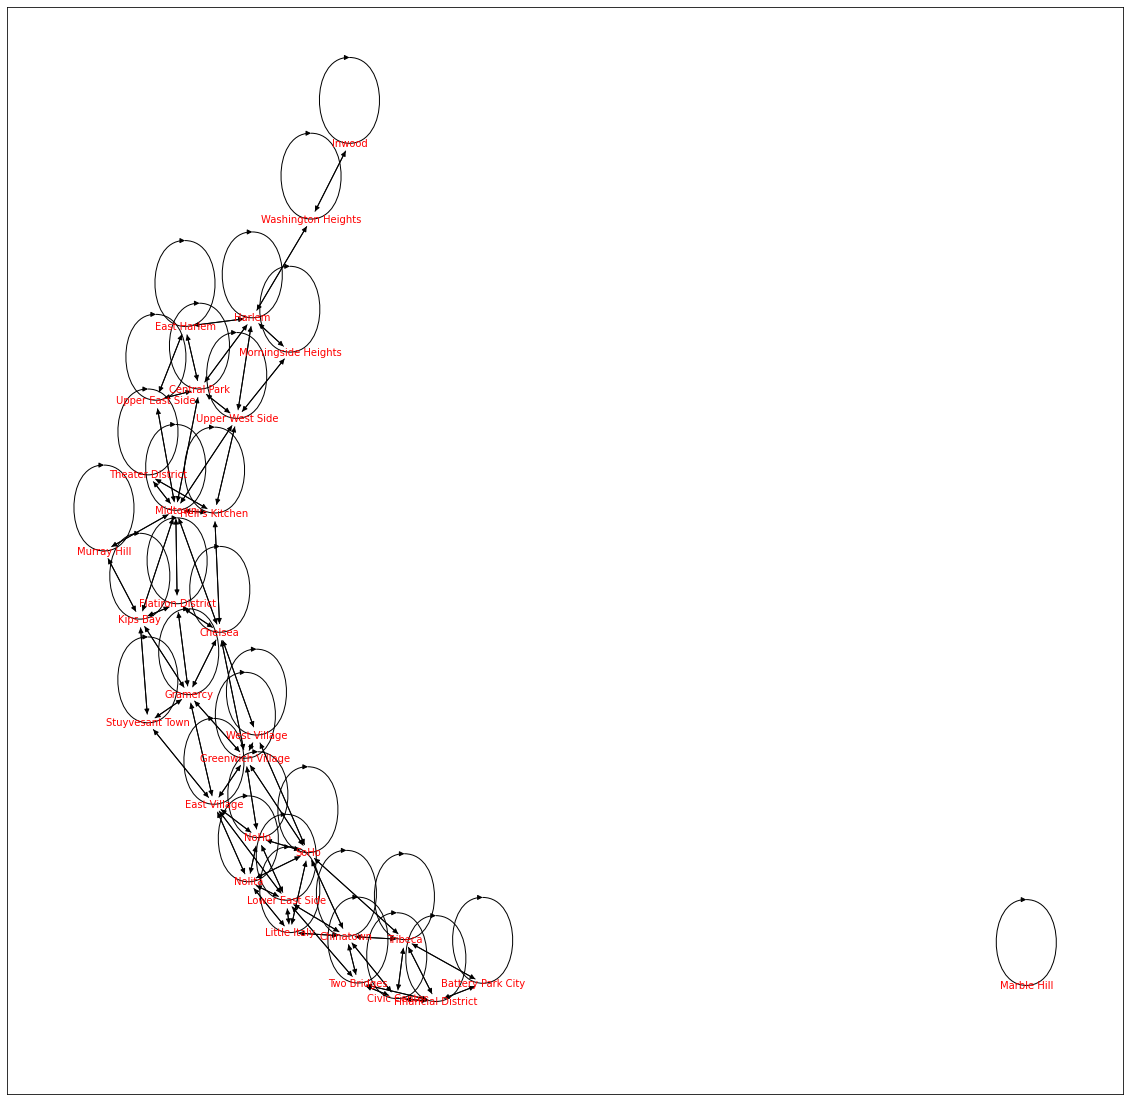

In [ ]:
sp_mx = sp.coo_matrix(adjacency_matrix)
G = dgl.from_scipy(sp_mx)
print_graph(dgl_graph=G,seed=8, node_labels=label_dict)

#DGL_pytorch Wave  Model
Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework
for Traffic Forecasting.
[code](https://github.com/dmlc/dgl/tree/master/examples/pytorch/stgcn_wave), [paper](https://arxiv.org/pdf/1709.04875v4.pdf)




##Model

In [ ]:
class TemporalConvLayer(nn.Module):
    """Temporal convolution layer.
    arguments
    ---------
    c_in : int
        The number of input channels (features)
    c_out : int
        The number of output channels (features)
    dia : int
        The dilation size
    """

    def __init__(self, c_in, c_out, dia=1):
        super(TemporalConvLayer, self).__init__()
        self.c_out = c_out
        self.c_in = c_in
        self.conv = nn.Conv2d(
            c_in, c_out, (2, 1), 1, dilation=dia, padding=(0, 0)
        )

    def forward(self, x):
        return torch.relu(self.conv(x))


class SpatioConvLayer(nn.Module):
    def __init__(self, c, Graph):  # c : hidden dimension Graph: graph matrix
        super(SpatioConvLayer, self).__init__()
        self.g = Graph
        self.gc = GraphConv(c, c, activation=torch.relu)
        # self.gc = ChebConv(c, c, 3)

    def init(self):
        stdv = 1.0 / math.sqrt(self.W.weight.size(1))
        self.W.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = x.transpose(0, 3)
        x = x.transpose(1, 3)
        output = self.gc(self.g, x)
        output = output.transpose(1, 3)
        output = output.transpose(0, 3)
        return torch.relu(output)


class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.fc = FullyConvLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)


class STGCN_WAVE(nn.Module):
    def __init__(
        self, blocks, n_his, n_areas, Graph, drop_prob, num_layers, device, control_str="TNTSTNTST"
    ):
        super(STGCN_WAVE, self).__init__()
        self.control_str = control_str  # model structure controller
        self.num_layers = len(control_str)
        self.layers = nn.ModuleList([])
        cnt = 0
        diapower = 0
        for i in range(self.num_layers):
            i_layer = control_str[i]
            if i_layer == "T":  # Temporal Layer
                self.layers.append(
                    TemporalConvLayer(blocks[cnt], blocks[cnt + 1], dia=2**diapower)
                )
                diapower += 1
                cnt += 1
            if i_layer == "S":  # Spatio Layer
                self.layers.append(SpatioConvLayer(blocks[cnt], Graph))
            if i_layer == "N":  # Norm Layer
                self.layers.append(nn.LayerNorm([n_his, blocks[cnt]]))
        self.output = OutputLayer(blocks[cnt], n_his + 1 - 2 ** (diapower), n_his)
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x):
        for i in range(self.num_layers):
            i_layer = self.control_str[i]
            if i_layer == "N":
                x = self.layers[i](x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
            else:
                x = self.layers[i](x)
        return self.output(x)

##Training

In [ ]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
blocks= [1, 16, 32, 64, 32, 16]
n_his=56 #history window
n_areas = adjacency_matrix.shape[0]
sp_mx = sp.coo_matrix(adjacency_matrix)
G = dgl.from_scipy(sp_mx)
drop_prob=0
num_layers = 9
control_str = "TNTSTNTST"

In [ ]:
torch.cuda.is_available()

False

In [ ]:
G = G.to(device)
loss = nn.MSELoss()
model = STGCN_WAVE(
blocks, n_his, n_areas, G, drop_prob, num_layers, device, control_str
).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [ ]:
epochs = 100
batch_size = 256
n_pred = 1

In [ ]:
#@title
x_train, y_train = data_transform(train_array, n_his, n_pred, device)
x_val, y_val = data_transform(val_array, n_his, n_pred, device)
x_test, y_test = data_transform(test_array, n_his, n_pred, device)
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [ ]:
model.layers

ModuleList(
  (0): TemporalConvLayer(
    (conv): Conv2d(4, 16, kernel_size=(2, 1), stride=(1, 1))
  )
  (1): LayerNorm((56, 16), eps=1e-05, elementwise_affine=True)
  (2): TemporalConvLayer(
    (conv): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), dilation=(2, 2))
  )
  (3): SpatioConvLayer(
    (gc): GraphConv(in=32, out=32, normalization=both, activation=<built-in method relu of type object at 0x7f85daaa9460>)
  )
  (4): TemporalConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(2, 1), stride=(1, 1), dilation=(4, 4))
  )
  (5): LayerNorm((56, 64), eps=1e-05, elementwise_affine=True)
  (6): TemporalConvLayer(
    (conv): Conv2d(64, 32, kernel_size=(2, 1), stride=(1, 1), dilation=(8, 8))
  )
  (7): SpatioConvLayer(
    (gc): GraphConv(in=32, out=32, normalization=both, activation=<built-in method relu of type object at 0x7f85daaa9460>)
  )
  (8): TemporalConvLayer(
    (conv): Conv2d(32, 16, kernel_size=(2, 1), stride=(1, 1), dilation=(16, 16))
  )
)

In [ ]:
#@title
import time
tls = []
vls = []
min_val_loss = np.inf

for epoch in range(1, epochs + 1):
    t0=time.time()
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), "stgcnwavemodel.pt")
    print(
        "epoch",
        epoch,
        ", train loss:",
        l_sum / n,
        ", validation loss:",
        val_loss,
        ", time:",
        time.time()-t0
    )
    tls.append(l_sum / n)
    vls.append(val_loss)

##Results

MinMax scaling to 0-1 and sigmoid activations funtions instead of relu seems to have better performance.

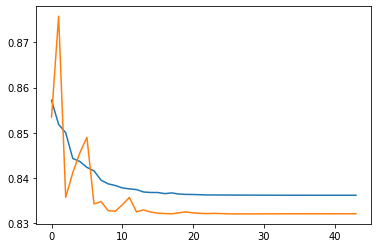

In [ ]:
#256 batch, theft crimes , best params, 270 *8H window , relu , standard normalization
plt.plot(tls[3:], label='train loss')
plt.plot(vls[3:], label='validation loss')

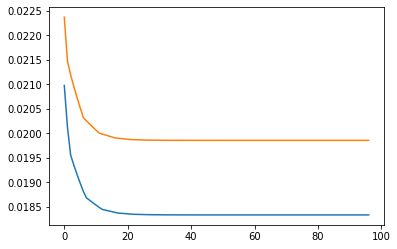

In [ ]:
#256 batch, theft crimes , best params, 365 *24H window
plt.plot(tls[3:], label='train loss')
plt.plot(vls[3:], label='validation loss')

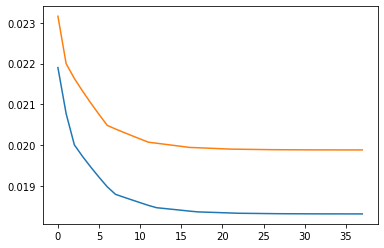

In [ ]:
#256 batch, theft crimes , best params, 365 *24H window
plt.plot(tls[3:], label='train loss')
plt.plot(vls[3:], label='validation loss')

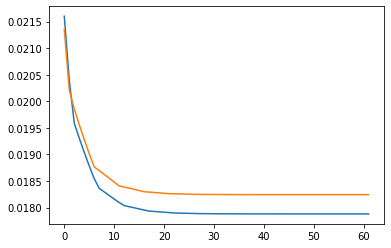

In [ ]:
#256 batch, theft crimes , best params, 270 *24H window
plt.plot(tls[3:], label='train loss')
plt.plot(vls[3:], label='validation loss')

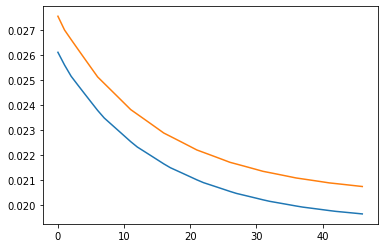

In [ ]:
#256 batch, theft crimes , best params, 270 *24H window
plt.plot(tls[3:], label='train loss')
plt.plot(vls[3:], label='validation loss')

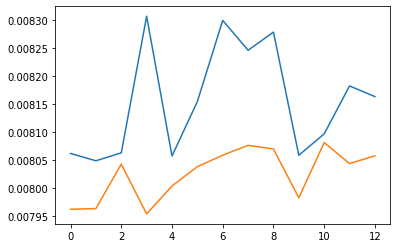

In [ ]:
#128 batch, theft crimes , best params, 270 *3 window
plt.plot(tls[1:], label='train loss')
plt.plot(vls[1:], label='validation loss')

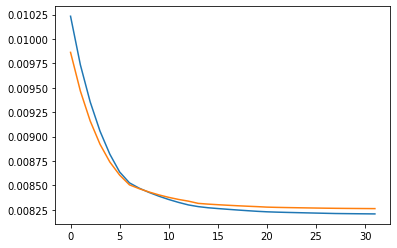

In [ ]:
#512 batch, all data, best params, 270 *8 window
plt.plot(tls[1:], label='train loss')
plt.plot(vls[1:], label='validation loss')

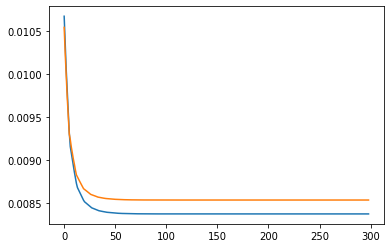

In [ ]:
#512 batch, all data, best params
plt.plot(tls[1:], label='train loss')
plt.plot(vls[1:], label='validation loss')

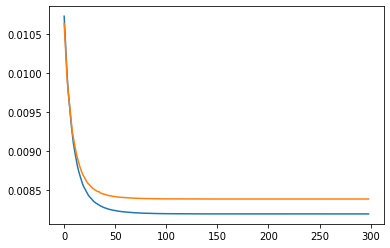

In [ ]:
#512 batch, all data
plt.plot(tls[1:], label='train loss')
plt.plot(vls[1:], label='validation loss')

In [ ]:
MAE, MAPE, RMSE = evaluate_metric(model,data_iter=test_iter, scaler=scaler)

In [ ]:
#24h * 365 group
print('MAE:', MAE)
print('MAPE:', MAPE)
print('RMSE:', RMSE)

MAE: 1.9399005106809006
MAPE: inf
RMSE: 3.023618230414551


In [ ]:
#24h * 365 group
print('MAE:', MAE)
print('MAPE:', MAPE)
print('RMSE:', RMSE)

MAE: 2.1542291800084246
MAPE: inf
RMSE: 3.3957262492633817


In [ ]:
#3h * 270 group
print('MAE:', MAE)
print('MAPE:', MAPE)
print('RMSE:', RMSE)

MAE: 2.2018836865583475
MAPE: inf
RMSE: 3.467298173642011


In [ ]:
print('MAE:', MAE)
print('MAPE:', MAPE)
print('RMSE:', RMSE)

MAE: 1.759466297455567
MAPE: inf
RMSE: 2.784518866320906


# Tuning

##Data Transformation Util

In [ ]:
def preprocess_data(nyc_borough_df, areas_geodf, Neighbours_df, borough,
                    date_range_from, date_range_to, freq,
                    train_size, val_size, batch_size, n_his, n_pred,  device):
    manhattan_n = Neighbours_df[Neighbours_df['neighborhood'].isin(areas_geodf[areas_geodf['borough']==borough]['neighborhood'])]
    area_time_df = nyc_borough_df.groupby([pd.Grouper(key='DATE_TIME',freq=freq),nyc_borough_df.neighborhood]).size().reset_index(name='count')
    area_time_df= area_time_df[['DATE_TIME','neighborhood','count']]
    table = pd.pivot_table(area_time_df, index=['DATE_TIME'], columns=['neighborhood'],values='count', fill_value=0.0)
    table = table.reset_index()
    datetime_series = pd.to_datetime(table['DATE_TIME'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    table=table.set_index(datetime_index)
    table.drop('DATE_TIME',axis=1,inplace=True)
    df = pd.crosstab(manhattan_n.neighborhood, manhattan_n.neighborhood)
    idx = df.columns.union(df.index)
    adjacency_matrix_df = df.reindex(index = idx, columns=idx, fill_value=0)
    manhattan_n = manhattan_n.set_index('neighborhood')
    for i in df.index.tolist():
        n_list = manhattan_n.loc[i]['NEIGHBORS'].split(',')
        for j in n_list:
            df.loc[i][j]=1
    adjacency_matrix = df.to_numpy()
    table = table[df.columns]
    new_date_range = pd.date_range(start = date_range_from, end = date_range_to ,freq=freq)
    table_df = table.reindex(new_date_range, fill_value=0.0)
    crime_array = table_df.to_numpy()
    column_list = list(df.columns)
    label_dict={}
    for i in range(len(column_list)):
        label_dict[i] = column_list[i]
    scaler = MinMaxScaler()
    scaler.fit(crime_array)
    crime_array = scaler.transform(crime_array)
    num_time_steps = crime_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = crime_array[:num_train]
    val_array = crime_array[num_train : (num_train + num_val)]
    test_array = crime_array[(num_train + num_val) :]
    x_train, y_train = data_transform(train_array, n_his, n_pred, device)
    x_val, y_val = data_transform(val_array, n_his, n_pred, device)
    x_test, y_test = data_transform(test_array, n_his, n_pred, device)
    train_data = torch.utils.data.TensorDataset(x_train, y_train)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=False)
    val_data = torch.utils.data.TensorDataset(x_val, y_val)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    test_data = torch.utils.data.TensorDataset(x_test, y_test)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    sp_mx = sp.coo_matrix(adjacency_matrix)
    G = dgl.from_scipy(sp_mx)
    G = G.to(device)
    return train_iter, val_iter, test_iter, adjacency_matrix, G, label_dict

##Model Arch

In [ ]:
class TemporalConvLayer(nn.Module):
    """Temporal convolution layer.
    arguments
    ---------
    c_in : int
        The number of input channels (features)
    c_out : int
        The number of output channels (features)
    dia : int
        The dilation size
    """

    def __init__(self, c_in, c_out, dia=1):
        super(TemporalConvLayer, self).__init__()
        self.c_out = c_out
        self.c_in = c_in
        self.conv = nn.Conv2d(
            c_in, c_out, (2, 1), 1, dilation=dia, padding=(0, 0)
        )

    def forward(self, x):
        return torch.sigmoid(self.conv(x))


class SpatioConvLayer(nn.Module):
    def __init__(self, c, Lk):  # c : hidden dimension Lk: graph matrix
        super(SpatioConvLayer, self).__init__()
        self.g = Lk
        self.gc = GraphConv(c, c, activation=torch.sigmoid)
        # self.gc = ChebConv(c, c, 3)

    def init(self):
        stdv = 1.0 / math.sqrt(self.W.weight.size(1))
        self.W.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = x.transpose(0, 3)
        x = x.transpose(1, 3)
        output = self.gc(self.g, x)
        output = output.transpose(1, 3)
        output = output.transpose(0, 3)
        return torch.sigmoid(output)


class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.fc = FullyConvLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)


class STGCN_WAVE(nn.Module):
    def __init__(
        self, blocks, n_his, n_nodes, Lk, p, device, control_str="TNTSTNTST"
    ):
        super(STGCN_WAVE, self).__init__()
        self.control_str = control_str  # model structure controller
        self.num_layers = len(control_str)
        self.layers = nn.ModuleList([])
        cnt = 0
        diapower = 0
        for i in range(self.num_layers):
            i_layer = control_str[i]
            if i_layer == "T":  # Temporal Layer
                self.layers.append(
                    TemporalConvLayer(blocks[cnt], blocks[cnt + 1], dia=2**diapower)
                )
                diapower += 1
                cnt += 1
            if i_layer == "S":  # Spatio Layer
                self.layers.append(SpatioConvLayer(blocks[cnt], Lk))
            if i_layer == "N":  # Norm Layer
                self.layers.append(nn.LayerNorm([n_nodes, blocks[cnt]]))
        self.output = OutputLayer(blocks[cnt], n_his + 1 - 2 ** (diapower), n_nodes)
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x):
        for i in range(self.num_layers):
            i_layer = self.control_str[i]
            if i_layer == "N":
                x = self.layers[i](x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
            else:
                x = self.layers[i](x)
        return self.output(x)

##Tune

In [ ]:
!wandb login --relogin
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

###Data Parameters

In [ ]:
# NYC Borough to work with (['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island'])
borough='Manhattan'
date_range_from = '2012-01-01'
date_range_to   = '2015-01-01'
freq = '8H'
train_size, val_size = 0.5, 0.2
batch_size = 256
n_his=270
n_pred = 1

### Model Parameters

In [ ]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
params = {
    'shuffle':{'values': [False]},
    'block1':{
        'values': [16, 32, 32, 64, 128]
        },
    'block2':{
        'values': [ 16, 32, 32, 64, 128]
        },
    'block3':{
        'values': [ 16, 32, 32, 64, 128]
        },
    'block4':{
        'values': [ 16, 32, 32, 64, 128]
        },
    'block5':{
        'values': [ 16, 32, 32, 64, 128]
        },
    'control_str': {
        'values': [ 'TNTSTNTST', 'TTSTTST', 'TTNSTSNSS', 'TNTSTNTST']
    },
    'drop_prob': {'values': [0]},
    'learning_rate': {'max': 0.1, 'min': 0.0001},
    'gamma':{'max': 0.9, 'min': 0.3},
    'step_size':{'values': [5, 7, 10]},


}
sweep_config['parameters'] = params
sweep_config['metric'] = metric

In [ ]:
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'block1': {'values': [16]},
                'block2': {'values': [32]},
                'block3': {'values': [64]},
                'block4': {'values': [128]},
                'block5': {'values': [64]},
                'control_str': {'values': ['TNTSTNTST']},
                'drop_prob': {'values': [0]},
                'gamma': {'max': 0.9, 'min': 0.3},
                'learning_rate': {'max': 0.1, 'min': 0.0001},
                'shuffle': {'values': [False]},
                'step_size': {'values': [7]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ST_DGL_PYTORCH_MODEL_PARAMS", entity="g-botsarakos")

Create sweep with ID: 2x6e3axy
Sweep URL: https://wandb.ai/g-botsarakos/ST_DGL_PYTORCH_MODEL_PARAMS/sweeps/2x6e3axy


In [ ]:
epochs = 50
loss = nn.MSELoss()

In [ ]:
#feeding data preparation
train_iter, val_iter, test_iter, adjacency_matrix, G, label_dict = preprocess_data(nyc_borough_df, areas_geodf, Neighbours_df, borough,
                    date_range_from, date_range_to, freq,
                    train_size, val_size, batch_size, n_his, n_pred,  device)

In [ ]:
#model instatiation
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        blocks = [1, config.block1, config.block2,config.block3, config.block4, config.block5]
        model = STGCN_WAVE(
        blocks, n_his, adjacency_matrix.shape[0],
        G, config.drop_prob, device, config.control_str
        ).to(device)
        optimizer = torch.optim.RMSprop(model.parameters(), config.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)

        #training
        min_val_loss = np.inf
        for epoch in range(1, epochs + 1):
            l_sum, n = 0.0, 0
            model.train()
            for x, y in train_iter:
                y_pred = model(x).view(len(x), -1)
                l = loss(y_pred, y)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                l_sum += l.item() * y.shape[0]
                n += y.shape[0]
            scheduler.step()
            val_loss = evaluate_model(model, loss, val_iter)
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(model.state_dict(), "stgcnwavemodel.pt")
            train_loss = l_sum / n

            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss
            })

In [ ]:
wandb.agent(sweep_id, function=train, count=10)

#METR_LA DATASET test
Testing traffic data


##Util

In [ ]:
def get_adjacency_matrix(distance_df, sensor_ids, normalized_k=0.1):
    """
    :param distance_df: data frame with three columns: [from, to, distance].
    :param sensor_ids: list of sensor ids.
    :param normalized_k: entries that become lower than normalized_k after normalization are set to zero for sparsity.
    :return: adjacency matrix
    """
    num_sensors = len(sensor_ids)
    dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
    dist_mx[:] = np.inf
    # Builds sensor id to index map.
    sensor_id_to_ind = {}
    for i, sensor_id in enumerate(sensor_ids):
        sensor_id_to_ind[sensor_id] = i
    # Fills cells in the matrix with distances.
    for row in distance_df.values:
        if row[0] not in sensor_id_to_ind or row[1] not in sensor_id_to_ind:
            continue
        dist_mx[sensor_id_to_ind[row[0]], sensor_id_to_ind[row[1]]] = row[2]

    # Calculates the standard deviation as theta.
    distances = dist_mx[~np.isinf(dist_mx)].flatten()
    std = distances.std()
    adj_mx = np.exp(-np.square(dist_mx / std))
    # Make the adjacent matrix symmetric by taking the max.
    # adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])

    # Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
    adj_mx[adj_mx < normalized_k] = 0
    return adj_mx

##Loading Data

In [ ]:
#mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
metr_df = pd.read_hdf('/content/drive/MyDrive/datasets/traffic_data/metr-la.h5')

In [ ]:
metr_df

In [ ]:
#34272 timesteps * 207 sensors
metr_df.shape

(34272, 207)

In [ ]:
metr_df.columns

Index(['773869', '767541', '767542', '717447', '717446', '717445', '773062',
       '767620', '737529', '717816',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=207)

In [ ]:
len(metr_df.columns)

207

In [ ]:
print(metr_df.head())

                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000  64.500  64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000   0.000   0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000   0.000   0.000   0.000000   0.000000  ...   

                        772167  769372     774204     769806  717590

In [ ]:
metr_df[:2]

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875


In [ ]:
tsdata = metr_df.to_numpy()

In [ ]:
with open('/content/drive/MyDrive/datasets/traffic_data/graph_sensor_ids.txt') as f:
    sensor_ids = f.read().strip().split(",")

In [ ]:
distance_df = pd.read_csv('/content/drive/MyDrive/datasets/traffic_data/distances_la_2012.csv', dtype={"from": "str", "to": "str"})

In [ ]:
distance_df

,from,to,cost
0,1201054,1201054,0.0
1,1201054,1201066,2610.9
2,1201054,1201076,2822.7
3,1201054,1201087,2911.5
4,1201054,1201100,7160.1
...,...,...,...
295369,825515,823663,9894.1
295370,825515,825494,475.6
295371,825515,825496,6458.6
295372,825515,825513,6934.2


In [ ]:
adj_mx = get_adjacency_matrix(distance_df, sensor_ids)

In [ ]:
sp_mx = sp.coo_matrix(adj_mx)
G = dgl.from_scipy(sp_mx)

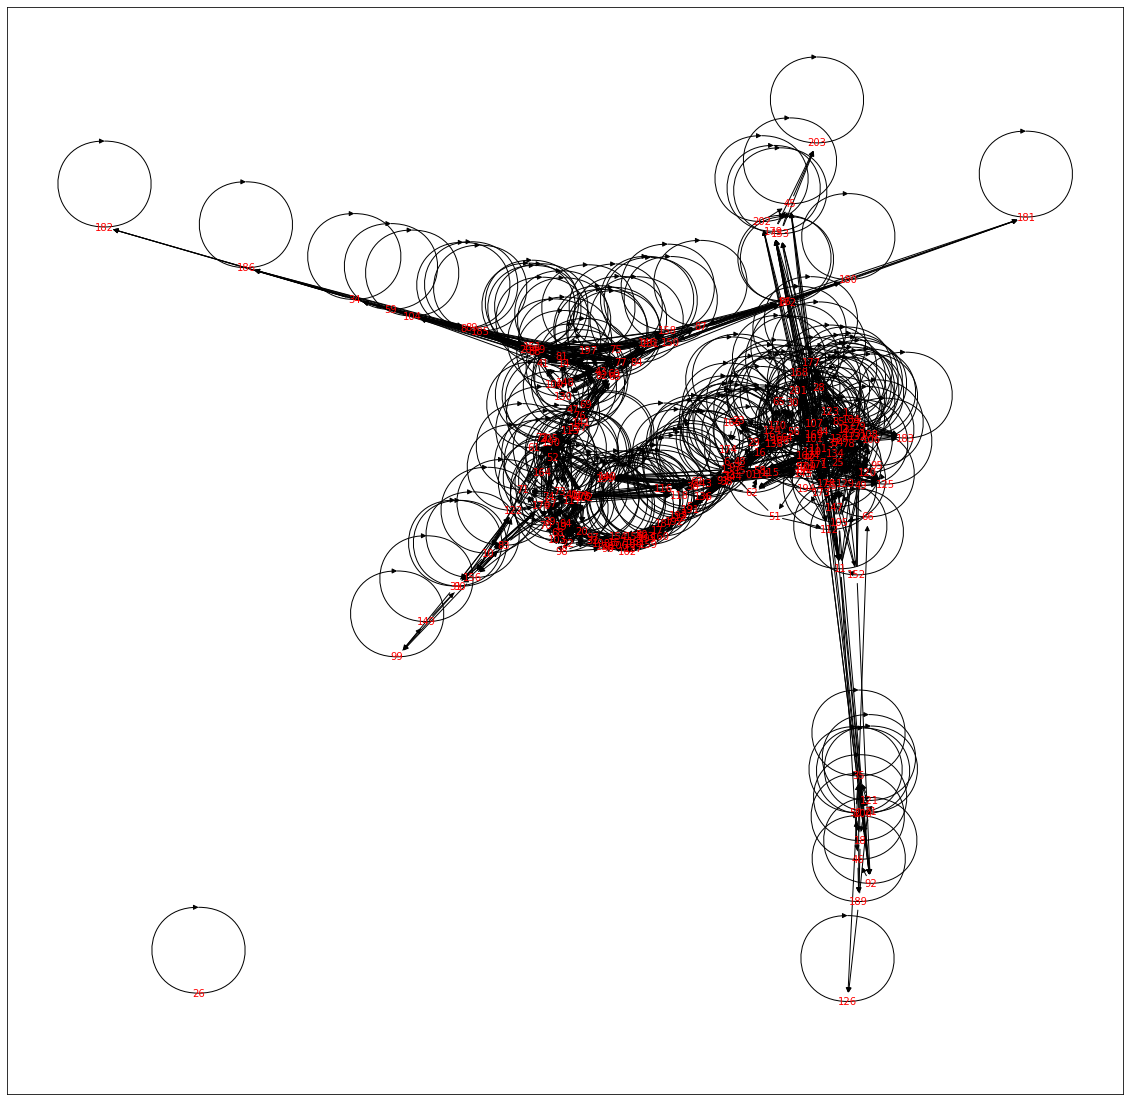

In [ ]:
print_graph(dgl_graph=G,seed=8, node_labels=None)

In [ ]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
blocks= [1, 16, 32, 64, 32, 128]

In [ ]:
n_his=144 #history window
n_areas = adj_mx.shape[0]
drop_prob=0
num_layers = 9
control_str = "TNTSTNTST"

In [ ]:
G = G.to(device)
loss = nn.MSELoss()
model = STGCN_WAVE(
blocks, n_his, n_areas, G, drop_prob, num_layers, device, control_str
).to(device)

In [ ]:
#save_path='/content/drive/MyDrive/models/stgcnwavemodel_traffic.pt'

In [ ]:
#model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
epochs = 50
batch_size = 64
n_pred = 5

In [ ]:
num_samples, num_nodes =metr_df.shape

In [ ]:

len_val = round(num_samples * 0.1)
len_train = round(num_samples * 0.7)
train_array = metr_df[:len_train]
val_array = metr_df[len_train : len_train + len_val]
test_array = metr_df[len_train + len_val :]

In [ ]:
scaler = MinMaxScaler()
train_array = scaler.fit_transform(train_array)
val_array = scaler.transform(val_array)
test_array = scaler.transform(test_array)

In [ ]:
x_train, y_train = data_transform(train_array, n_his, n_pred, device)
x_val, y_val = data_transform(val_array, n_his, n_pred, device)
x_test, y_test = data_transform(test_array, n_his, n_pred, device)
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=False)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

##Train

In [ ]:
#model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
import time

In [ ]:
tls = []
vls = []
min_val_loss = np.inf

for epoch in range(1, epochs + 1):
    t0= time.time()
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/models/stgcnwavemodel_traffic_l.pt")
    print(
        "epoch",
        epoch,
        ", train loss:",
        l_sum / n,
        ", validation loss:",
        val_loss,
        ", time:",
        time.time()-t0
    )
    tls.append(l_sum / n)
    vls.append(val_loss)

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 , train loss: 0.17929258760824088 , validation loss: 0.08105069005667545 , time: 689.3264508247375
epoch 2 , train loss: 0.0692156985118347 , validation loss: 0.07735045091035964 , time: 678.1975123882294
epoch 3 , train loss: 0.0643020043431085 , validation loss: 0.07668331534788694 , time: 677.963828086853
epoch 4 , train loss: 0.06421446063822622 , validation loss: 0.07597714635845253 , time: 678.4974029064178
epoch 5 , train loss: 0.06430111459343607 , validation loss: 0.07476857776996237 , time: 676.8938443660736
epoch 6 , train loss: 0.06082298509708777 , validation loss: 0.06802340151652321 , time: 678.1928141117096
epoch 7 , train loss: 0.04689112974454303 , validation loss: 0.05811920094510053 , time: 679.1460864543915
epoch 8 , train loss: 0.04279426290097728 , validation loss: 0.05469072417624845 , time: 678.4721410274506
epoch 9 , train loss: 0.03989793431939012 , validation loss: 0.05220887066297519 , time: 677.2727131843567
epoch 10 , train loss: 0.037882356204929

KeyboardInterrupt: ignored

aprox 10 - 15 minutes per epoch

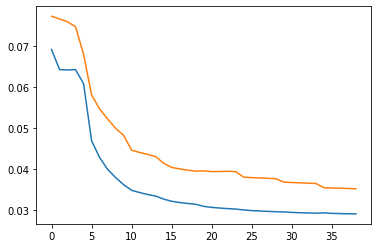

In [ ]:
#large model
plt.plot(tls[1:], label='train loss')
plt.plot(vls[1:], label='validation loss')

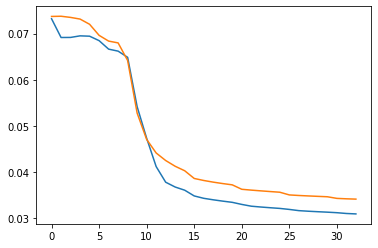

In [ ]:
#small model 8h training
#blocks = [1,16,32,64, 16, 16]
plt.plot(tls, label='train loss')
plt.plot(vls, label='validation loss')

In [ ]:
save_path='/content/drive/MyDrive/models/stgcnwavemodel_traffic_l.pt'

In [ ]:
best_model = STGCN_WAVE(
blocks, n_his, n_areas, G, drop_prob, num_layers, device, control_str
).to(device)
best_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
l = evaluate_model(best_model, loss, test_iter)
MAE, MAPE, RMSE = evaluate_metric(best_model, test_iter, scaler)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

large_model



test loss: 0.043219811391655344
MAE: 8.852203559914964 , MAPE: inf , RMSE: 14.53027026082821

small_model

test loss: 0.04165270282280577
MAE: 8.645961367305661 , MAPE: inf , RMSE: 14.264038995385292

#Multilayer Model with days-hours- features
Testing Crime Data with temporal features

In [ ]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
blocks= [4, 16, 32, 64, 32, 16]
n_his=56 #history window
n_areas = adjacency_matrix.shape[0]
sp_mx = sp.coo_matrix(adjacency_matrix)
G = dgl.from_scipy(sp_mx)
drop_prob=0
num_layers = 9
control_str = "TSTSTSTST"

In [ ]:
epochs = 100
batch_size = 256
n_pred = 1

In [ ]:
fused_crime_array = np.stack((crime_array, week_days,year_days, day_hours ),axis=1)
fused_crime_array.shape

(9865, 4, 32)

In [ ]:
class TemporalConvLayer(nn.Module):
    """Temporal convolution layer.
    arguments
    ---------
    c_in : int
        The number of input channels (features)
    c_out : int
        The number of output channels (features)
    dia : int
        The dilation size
    """

    def __init__(self, c_in, c_out, dia=1):
        super(TemporalConvLayer, self).__init__()
        self.c_out = c_out
        self.c_in = c_in
        self.conv = nn.Conv2d(
            c_in, c_out, (2, 1), 1, dilation=dia, padding=(0, 0)
        )

    def forward(self, x):
        return torch.relu(self.conv(x))


class SpatioConvLayer(nn.Module):
    def __init__(self, c, Graph):  # c : hidden dimension Graph: graph matrix
        super(SpatioConvLayer, self).__init__()
        self.g = Graph
        self.gc = GraphConv(c, c, activation=torch.relu)
        # self.gc = ChebConv(c, c, 3)

    def init(self):
        stdv = 1.0 / math.sqrt(self.W.weight.size(1))
        self.W.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = x.transpose(0, 3)
        x = x.transpose(1, 3)
        output = self.gc(self.g, x)
        output = output.transpose(1, 3)
        output = output.transpose(0, 3)
        return torch.relu(output)


class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        #self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.fc = FullyConvLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
       # x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_t1)
        return self.fc(x_t2)


class STGCN_WAVE(nn.Module):
    def __init__(
        self, blocks, n_his, n_areas, Graph, drop_prob, num_layers, device, control_str="TNTSTNTST"
    ):
        super(STGCN_WAVE, self).__init__()
        self.control_str = control_str  # model structure controller
        self.num_layers = len(control_str)
        self.layers = nn.ModuleList([])
        cnt = 0
        diapower = 0
        for i in range(self.num_layers):
            i_layer = control_str[i]
            if i_layer == "T":  # Temporal Layer
                self.layers.append(
                    TemporalConvLayer(blocks[cnt], blocks[cnt + 1], dia=2**diapower)
                )
                diapower += 1
                cnt += 1
            if i_layer == "S":  # Spatio Layer
                self.layers.append(SpatioConvLayer(blocks[cnt], Graph))
            if i_layer == "N":  # Norm Layer
                self.layers.append(nn.LayerNorm([n_his, blocks[cnt]]))
        self.output = OutputLayer(blocks[cnt], n_his + 1 - 2 ** (diapower), n_his)
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x):
        for i in range(self.num_layers):
            i_layer = self.control_str[i]
            if i_layer == "N":
                x = self.layers[i](x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
            else:
                x = self.layers[i](x)
        return self.output(x)

In [ ]:
def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train,:, :]
    #mean, std = train_array.mean(axis=0), train_array.std(axis=0)
    #train_array = (train_array - mean) / std
    val_array = data_array[num_train : (num_train + num_val),:]
    test_array = data_array[(num_train + num_val) :,:]
    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(fused_crime_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (4932, 4, 32)
validation set size: (1973, 4, 32)
test set size: (2960, 4, 32)


In [ ]:
def data_multi_dim_transform(data, n_his, n_pred, device):
    # produce data slices for training and testing
    n_route = data.shape[2]
    l =data.shape[0]
    num = l - n_his - n_pred

    x = np.zeros([num, data.shape[1], n_his, n_route])
    y = np.zeros([num, n_route])
    cnt = 0
    for i in range(l - n_his - n_pred):
        head = i
        tail = i + n_his
        x[cnt, :, :, :] = data[head:tail,:,:].reshape(data.shape[1], n_his, n_route)
        y[cnt] = data[tail + n_pred - 1, 0]
        cnt += 1
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

In [ ]:
x_train, y_train = data_multi_dim_transform(train_array, n_his, n_pred, device)
x_val, y_val = data_multi_dim_transform(val_array, n_his, n_pred, device)
x_test, y_test = data_multi_dim_transform(test_array, n_his, n_pred, device)
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [ ]:
G = G.to(device)
loss = nn.MSELoss()
model = STGCN_WAVE(
blocks, n_his, n_areas, G, drop_prob, num_layers, device, control_str
).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [ ]:
model.layers

ModuleList(
  (0): TemporalConvLayer(
    (conv): Conv2d(4, 16, kernel_size=(2, 1), stride=(1, 1))
  )
  (1): SpatioConvLayer(
    (gc): GraphConv(in=16, out=16, normalization=both, activation=<built-in method relu of type object at 0x7fe818404460>)
  )
  (2): TemporalConvLayer(
    (conv): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), dilation=(2, 2))
  )
  (3): SpatioConvLayer(
    (gc): GraphConv(in=32, out=32, normalization=both, activation=<built-in method relu of type object at 0x7fe818404460>)
  )
  (4): TemporalConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(2, 1), stride=(1, 1), dilation=(4, 4))
  )
  (5): SpatioConvLayer(
    (gc): GraphConv(in=64, out=64, normalization=both, activation=<built-in method relu of type object at 0x7fe818404460>)
  )
  (6): TemporalConvLayer(
    (conv): Conv2d(64, 32, kernel_size=(2, 1), stride=(1, 1), dilation=(8, 8))
  )
  (7): SpatioConvLayer(
    (gc): GraphConv(in=32, out=32, normalization=both, activation=<built-in method relu of ty

In [ ]:
import time
tls = []
vls = []
min_val_loss = np.inf

for epoch in range(1, epochs + 1):
    t0=time.time()
    l_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.item() * y.shape[0]
        n += y.shape[0]
    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), "stgcnwavemodel.pt")
    print(
        "epoch",
        epoch,
        ", train loss:",
        l_sum / n,
        ", validation loss:",
        val_loss,
        ", time:",
        time.time()-t0
    )
    tls.append(l_sum / n)
    vls.append(val_loss)

epoch 1 , train loss: 1.8958191720277835 , validation loss: 0.9761654131098928 , time: 12.321488380432129
epoch 2 , train loss: 0.9962129542521941 , validation loss: 0.9646904377698401 , time: 2.808425188064575
epoch 3 , train loss: 0.9959451224375994 , validation loss: 0.9750615063440327 , time: 2.8090317249298096
epoch 4 , train loss: 0.9963209831042168 , validation loss: 0.9586605448314691 , time: 2.8042383193969727
epoch 5 , train loss: 0.994717338794317 , validation loss: 0.9654401983746905 , time: 2.833343982696533
epoch 6 , train loss: 0.9952175546303773 , validation loss: 0.9613246855506817 , time: 3.640519380569458
epoch 7 , train loss: 0.9941969484182505 , validation loss: 0.9609005380274109 , time: 2.8509552478790283
epoch 8 , train loss: 0.9937489930910942 , validation loss: 0.9584036328847324 , time: 2.815934419631958
epoch 9 , train loss: 0.9933068769528316 , validation loss: 0.9574499833310074 , time: 2.8207945823669434
epoch 10 , train loss: 0.993045752060719 , validati

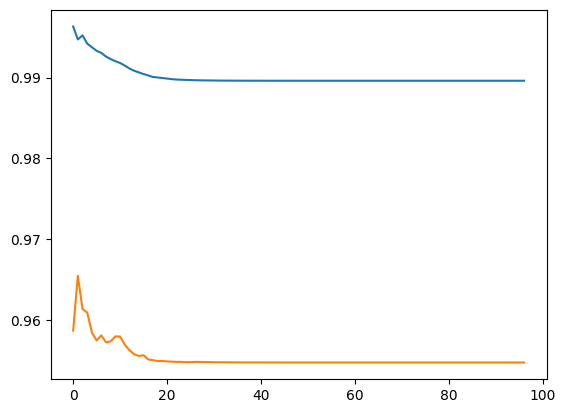

In [ ]:
plt.plot(tls[3:], label='train loss')
plt.plot(vls[3:], label='validation loss')

In [ ]:
MAE, MAPE, RMSE = evaluate_metric(model,data_iter=test_iter, scaler=scaler)

In [ ]:
print('MAE:', MAE)
print('MAPE:', MAPE)
print('RMSE:', RMSE)

MAE: 0.9844485080029874
MAPE: 5667367.904814412
RMSE: 1.5447938283395883
